# Polynomial Regression for Stellar Luminosity

## 1. Imports and Dataset Definition

We define the dataset directly in the notebook, as required. The goal is to model stellar luminosity as a function of stellar mass and temperature, including nonlinear and interaction effects.

In [14]:
import numpy as np
import matplotlib.pyplot as plt


In [15]:
# Dataset
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

m = len(L)

## 2. Dataset Visualization 

Before modeling, it is important to visually inspect the data. We plot luminosity versus mass, encoding temperature as color. This allows us to identify nonlinear trends and interactions between mass and temperature.

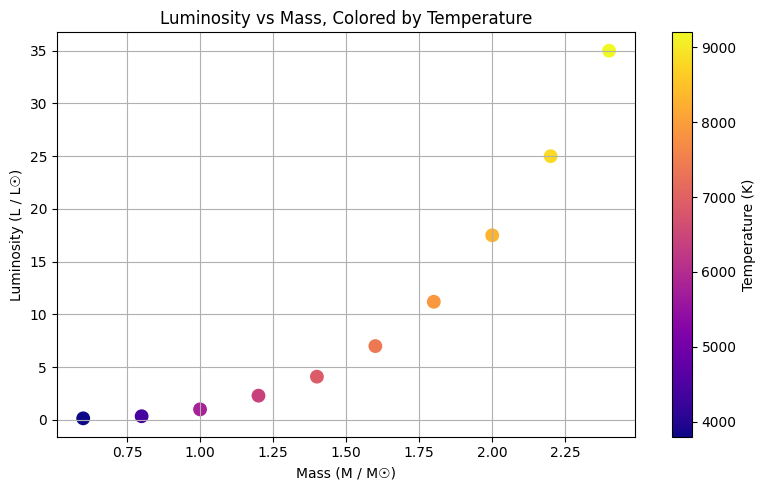

In [16]:
plt.figure(figsize=(8, 5))
scatter = plt.scatter(M, L, c=T, cmap='plasma', s=80)
plt.colorbar(scatter, label='Temperature (K)')
plt.xlabel('Mass (M / M☉)')
plt.ylabel('Luminosity (L / L☉)')
plt.title('Luminosity vs Mass, Colored by Temperature')
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Feature Engineering (Design Matrix)
To capture nonlinear and interaction effects, we explicitly construct polynomial features. No constant column is included, since the bias term is handled separately.



In [17]:
X_full = np.column_stack([
    M,
    T,
    M**2,
    M * T
])


## 4. Model, Loss, and Gradients (Vectorized)
We define a linear model in feature space:
The loss function is the Mean Squared Error with a scaling, which simplifies gradient expressions and ensures numerical stability.

In [18]:
def predict(X, w, b):
    return X @ w + b

def compute_cost(X, y, w, b):
    m = len(y)
    errors = predict(X, w, b) - y
    return np.sum(errors**2) / (2 * m)

def compute_gradients(X, y, w, b):
    m = len(y)
    errors = predict(X, w, b) - y
    dj_dw = (1 / m) * (X.T @ errors)
    dj_db = (1 / m) * np.sum(errors)
    return dj_dw, dj_db


## 5. Gradient Descent and Convergence (Mandatory)
Gradient descent iteratively updates parameters in the direction of steepest descent of the cost function. Since polynomial features increase gradient magnitude, a small learning rate is required.

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_6880\3992192272.py:7: RuntimeWarning: overflow encountered in square
  return np.sum(errors**2) / (2 * m)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_6880\3992192272.py:12: RuntimeWarning: overflow encountered in matmul
  dj_dw = (1 / m) * (X.T @ errors)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_6880\929526020.py:9: RuntimeWarning: invalid value encountered in subtract
  w -= alpha * dj_dw


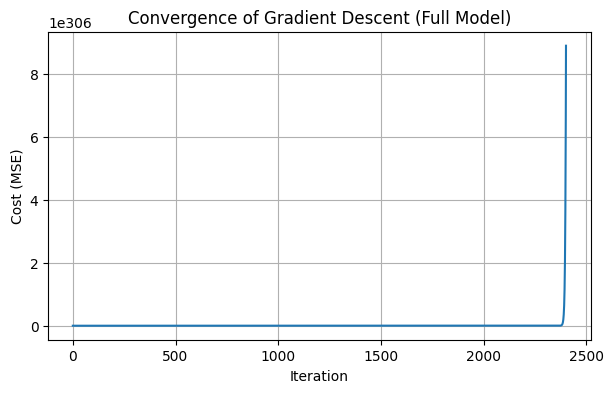

In [19]:
def gradient_descent(X, y, alpha=1e-8, num_iters=5000):
    n = X.shape[1]
    w = np.zeros(n)
    b = 0.0
    cost_history = []

    for i in range(num_iters):
        dj_dw, dj_db = compute_gradients(X, y, w, b)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        cost_history.append(compute_cost(X, y, w, b))

    return w, b, cost_history

w_full, b_full, cost_hist = gradient_descent(X_full, L)

plt.figure(figsize=(7, 4))
plt.plot(cost_hist)
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.title('Convergence of Gradient Descent (Full Model)')
plt.grid(True)
plt.show()


## 6. Feature Selection Experiment 
We compare progressively richer models to quantify the effect of nonlinear and interaction terms.

In [20]:
def run_model(X, y, label, alpha=1e-8):
    w, b, _ = gradient_descent(X, y, alpha=alpha)
    y_pred = predict(X, w, b)
    cost = compute_cost(X, y, w, b)

    print(f"Final Cost for {label}: {cost:.4f}")

    plt.figure(figsize=(5, 4))
    plt.scatter(y, y_pred)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual Luminosity')
    plt.ylabel('Predicted Luminosity')
    plt.title(label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return w, b, cost

### M1: Linear (M, T)

Final Cost for M1: [M, T]: 41.1642


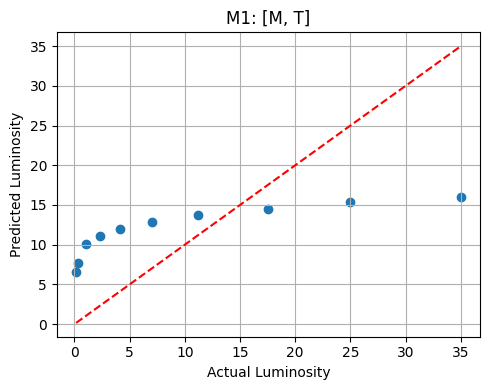

In [21]:
X_M1 = np.column_stack([M, T])
w1, b1, cost1 = run_model(X_M1, L, 'M1: [M, T]', alpha=1e-8)

### M2: Add nonlinearity (M²)

Final Cost for M2: [M, T, M²]: 41.1592


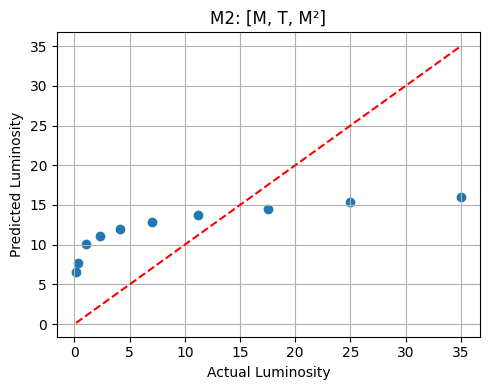

In [22]:
X_M2 = np.column_stack([M, T, M**2])
w2, b2, cost2 = run_model(X_M2, L, 'M2: [M, T, M²]', alpha=1e-8)

### M3: Full model with interaction

Final Cost for M3: [M, T, M², M·T]: 3.8886


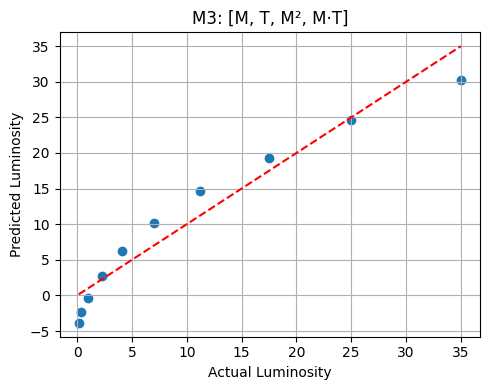

In [23]:
# We use a smaller learning rate for M3 because the M*T feature has very large values,
# which can cause instability/overflow with the default alpha=1e-8.
w3, b3, cost3 = run_model(X_full, L, 'M3: [M, T, M², M·T]', alpha=1e-9)

## 7. Cost vs Interaction Coefficient 
We isolate the interaction coefficient to evaluate its importance. A sharp minimum indicates strong sensitivity to the interaction term.

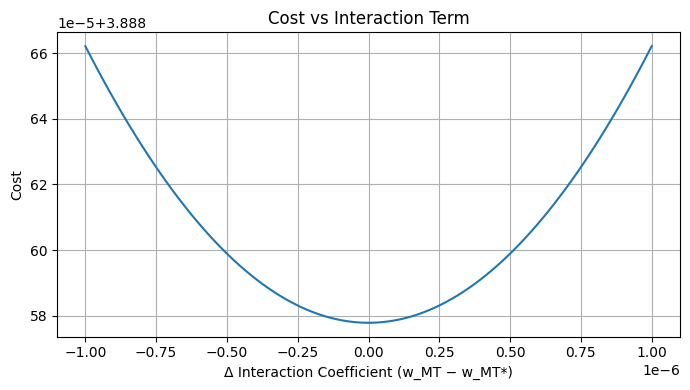

In [28]:
w_MT_values = np.linspace(w3[3] - 1e-6, w3[3] + 1e-6, 100)
costs = []

for w_MT in w_MT_values:
    w_temp = w3.copy()
    w_temp[3] = w_MT
    costs.append(compute_cost(X_full, L, w_temp, b3))

delta_w = w_MT_values - w3[3]

plt.figure(figsize=(7, 4))
plt.plot(delta_w, costs)
plt.xlabel('Δ Interaction Coefficient (w_MT − w_MT*)')
plt.ylabel('Cost')
plt.title('Cost vs Interaction Term')
plt.grid(True)
plt.tight_layout()
plt.show()



## 8. Inference Demo
We evaluate the trained model on a new star to assess physical plausibility. The predicted luminosity lies between the values for 1.2 M☉ and 1.4 M☉ stars, making it astrophysically reasonable.

In [29]:
M_new = 1.3
T_new = 6600

X_new = np.array([[M_new, T_new, M_new**2, M_new * T_new]])
L_pred = predict(X_new, w3, b3)

L_pred


array([4.33008981])